# Predicting Customer Lifetime Value

How do we find and market to high value customers? How do we justify large marketing budgets? Part of the equation is predicting customer lifetime value (CLV). It is important to get a sense of what our CLV is for a given customer, and to contextualize that with the cost to acquire new customers.

There are many ways to estimate CLV - it is essentially a prediction of the amount of money a given customer spends on our products/services over a certain time period of time (not necessarily an actual human lifetime). In this case study, we're going to look at the 3-month CLV of customers.

We're going to use a Regression model to predict the 3-month CLV of the final month of the dataset. Making a prediction based on past data is a bit more complicated then a regular model where you use current data to predict other current data. We'll explore this down below.

In [1]:
%load_ext autoreload
%autoreload 2

import helpers as hp

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('Online Retail.csv', index_col=0)
df.index = df.index.map(str)
df = df[df['Quantity'] > 0]
df = df[~df['CustomerID'].isnull()]

# Let's take out anything newer than December 2011.
df = df[df['InvoiceDate'] < '2011-12-01']

# Add the total sales value
df['Sales'] = df['Quantity'] * df['UnitPrice']

/opt/miniconda3/envs/ds-galeria/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [4]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceDate'].head()

0   2010-12-01 08:26:00
1   2010-12-01 08:26:00
2   2010-12-01 08:26:00
3   2010-12-01 08:26:00
4   2010-12-01 08:26:00
Name: InvoiceDate, dtype: datetime64[ns]

We're going to do some feature engineering based on what we think are features that would be good predictors of CLV. We'll start with sales and then move on to thinks like purchase frequency.

Let's look at the total sales per customer and per invoice.

In [5]:
orders_df = df.groupby(['CustomerID', 'InvoiceNo']).agg(
    {'Sales' : sum, 'InvoiceDate': max}
)
orders_df.head()

Sales         InvoiceDate
CustomerID InvoiceNo                              
12346.0    541431     77183.60 2011-01-18 10:01:00
12347.0    537626       711.79 2010-12-07 14:57:00
           542237       475.39 2011-01-26 14:30:00
           549222       636.25 2011-04-07 10:43:00
           556201       382.52 2011-06-09 13:01:00

In [6]:
def gb_mean(x):
    return x.mean()

def gb_count(x):
    return x.count()

def gb_purchase_duration(x):
    """Count time between first and last purchase."""
    return (x.max() - x.min()).days

def gb_avg_frequency(x):
    """Calculate the avg number of days between purchases."""
    return (x.max() - x.min()).days/x.count()


# Let's change the __name__ property in each func to
# Control the naming of the resulting columns in the DataFrame.
gb_mean.__name__ = 'avg'
gb_count.__name__ = 'count'
gb_purchase_duration.__name__ = 'purchase_duration'
gb_avg_frequency.__name__ = 'purchase_frequency'

summary_df = orders_df.reset_index().groupby('CustomerID').agg(
    {'Sales': [min, max, sum, gb_mean, gb_count],
     'InvoiceDate': [min, max, gb_purchase_duration,
                     gb_avg_frequency]}
)
summary_df.head()

Sales                                          \
                 min       max       sum           avg count   
CustomerID                                                     
12346.0     77183.60  77183.60  77183.60  77183.600000   1.0   
12347.0       382.52   1294.32   4085.18    680.863333   6.0   
12348.0       227.44    892.80   1797.24    449.310000   4.0   
12349.0      1757.55   1757.55   1757.55   1757.550000   1.0   
12350.0       334.40    334.40    334.40    334.400000   1.0   

                   InvoiceDate                                        \
                           min                 max purchase_duration   
CustomerID                                                             
12346.0    2011-01-18 10:01:00 2011-01-18 10:01:00                 0   
12347.0    2010-12-07 14:57:00 2011-10-31 12:25:00               327   
12348.0    2010-12-16 19:09:00 2011-09-25 13:13:00               282   
12349.0    2011-11-21 09:51:00 2011-11-21 09:51:00                 0   
12350.0    2011-02-02 16:01:00 2011-02-02 16:01:00                 0   

                               
           purchase_frequency  
CustomerID                     
12346.0                   0.0  
12347.0                  54.5  
12348.0                  70.5  
12349.0                   0.0  
12350.0                   0.0

What features do we have so far?

In [7]:
for col in summary_df.columns:
    print(col)

('Sales', 'min')
('Sales', 'max')
('Sales', 'sum')
('Sales', 'avg')
('Sales', 'count')
('InvoiceDate', 'min')
('InvoiceDate', 'max')
('InvoiceDate', 'purchase_duration')
('InvoiceDate', 'purchase_frequency')


We don't want our column names to be tuples, so let's rename them.

In [8]:
summary_df.columns = ['_'.join(col).lower() 
                      for col in summary_df.columns]
list(summary_df.columns)

['sales_min',
 'sales_max',
 'sales_sum',
 'sales_avg',
 'sales_count',
 'invoicedate_min',
 'invoicedate_max',
 'invoicedate_purchase_duration',
 'invoicedate_purchase_frequency']

Let's look at the distribution of the number of purchases made by each customer.

In [9]:
summary_df = summary_df[
    summary_df['invoicedate_purchase_duration'] > 0
]

Text(0, 0.5, 'Count')

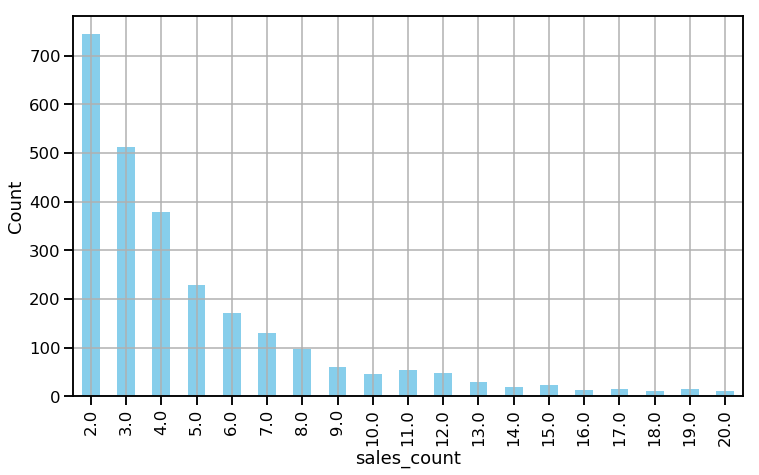

In [10]:
ax = summary_df.groupby('sales_count').count()['sales_avg'][:20].plot(
    kind='bar', color='skyblue', figsize=(12, 7), grid=True
)
ax.set_ylabel('Count')

The amount of purchases per customer decreases exponentially, so we have a lot of customers with a few purchases and very few with more than 10 purchases.

Now let's look at the number of days between purchases.

Text(0, 0.5, 'Count')

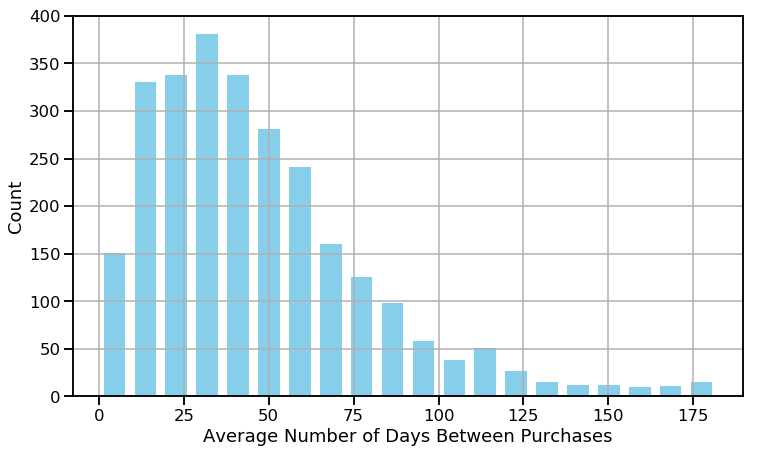

In [11]:
ax = summary_df['invoicedate_purchase_frequency'].hist(
    bins=20, color='skyblue', rwidth=0.7, figsize=(12, 7),
    grid=True
)
ax.set_xlabel('Average Number of Days Between Purchases')
ax.set_ylabel('Count')

The number of days between purchases for each customer follows what looks like a lognormal distribution (or similarly shaped distribution). This is useful to know as there looks to be a "sweet spot" beyond which the number of repeat buyers drops off. That sweet spot is about 1-2 months.

## Binning the Data into 3-Month Segments
We're going to bin the data into 3-month segments and then try to predict the CLV of the final 3-month period.



In [12]:
clv_freq = '3M'

# data_df = orders_df.reset_index().groupby([
#     'CustomerID',
#     pd.Grouper(key='InvoiceDate', freq=clv_freq)
# ]).agg({
#     'Sales': [sum, gb_mean, gb_count],
# })

# data_df.columns = ['_'.join(col).lower() for col in data_df.columns]
# data_df = data_df.reset_index()
# data_df.head()

def bin_ts_data(inpdf, idcol, timecol, aggcol, freq):
    """Bin time series data into time chunks."""
    # Custom grouper for datetime dtype col.
    data_df = inpdf.reset_index().groupby([
        idcol, pd.Grouper(key=timecol, freq=freq)
    ]).agg({aggcol: [sum, gb_mean, gb_count]})
    # Rename the columns from tuples to single strings.
    data_df.columns = ['_'.join(col).lower() for col in data_df.columns]
    # Reset the index from idcol/datecol to a generic index.
    data_df = data_df.reset_index()
    return data_df


data_df = bin_ts_data(orders_df, 'CustomerID',
                      'InvoiceDate', 'Sales', clv_freq)
data_df.head()

,CustomerID,InvoiceDate,sales_sum,sales_avg,sales_count
0,12346.0,2011-03-31,77183.60,77183.600,1.0
1,12347.0,2010-12-31,711.79,711.790,1.0
2,12347.0,2011-03-31,475.39,475.390,1.0
3,12347.0,2011-06-30,1018.77,509.385,2.0
4,12347.0,2011-09-30,584.91,584.910,1.0


In [13]:
def encode_time_chunks(inpdf, timecol, reverse=True):
    """Encode time chunks into strings."""
    # Explicitly take first 10 chars to leave out time stamps.
    time_map = {
        str(x)[:10]: 'M_%s' % (i+1) for i, x in enumerate(
            sorted(inpdf.reset_index()[timecol].unique(),
                   reverse=reverse)
        )
    }
    mcol = inpdf[timecol].apply(lambda x: time_map[str(x)[:10]])
    return mcol

# Encoding the month
# date_month_map = {
#     str(x)[:10]: 'M_%s' % (i+1) for i, x in enumerate(
#         sorted(data_df.reset_index()['InvoiceDate'].unique(),
#                reverse=True)
#     ) 
# }

# data_df['M'] = data_df['InvoiceDate'].apply(
#     lambda x: date_month_map[str(x)[:10]]
# )
data_df['M'] = encode_time_chunks(data_df, 'InvoiceDate')
data_df.head()

,CustomerID,InvoiceDate,sales_sum,sales_avg,sales_count,M
0,12346.0,2011-03-31,77183.60,77183.600,1.0,M_4
1,12347.0,2010-12-31,711.79,711.790,1.0,M_5
2,12347.0,2011-03-31,475.39,475.390,1.0,M_4
3,12347.0,2011-06-30,1018.77,509.385,2.0,M_3
4,12347.0,2011-09-30,584.91,584.910,1.0,M_2


The above code encoded the quarters by numbering them in terms of how far in the past they are compared to the latest quarter. The latest quarter is M_1 (2011-12-31). 

To explain the model we are about to build a little more, our model will have features that represent the past behaviour of each customer. This past behaviour will be then used as predictors for the future behaviour. To make this happen, we first have to do some transformation of the dataset.

In [14]:
def build_features_df(inpdf, idcol, chunk_col, target_chunk, feat_cols):
    """Build time series features with pivot table."""
    features_df = pd.pivot_table(
        inpdf.loc[inpdf[chunk_col] != target_chunk],
        values=feat_cols,
        columns=chunk_col,
        index=idcol
    )
    features_df.columns = ['_'.join(col) for col in
                           features_df.columns]
    features_df = features_df.fillna(0.)
    return features_df

#features_df = pd.pivot_table(
#    data_df.loc[data_df['M'] != 'M_1'],
#    values=['sales_sum', 'sales_avg', 'sales_count'],
#    columns='M',
#    index='CustomerID'
#)

#features_df.columns = ['_'.join(col) for
#                       col in features_df.columns]
#features_df = features_df.fillna(0.)  # encoded nans with 0.
features_df = build_features_df(
    data_df, 'CustomerID', 'M', 'M_1',
    ['sales_sum', 'sales_avg', 'sales_count']
)
features_df.head()

,sales_avg_M_2,sales_avg_M_3,sales_avg_M_4,sales_avg_M_5,sales_count_M_2,sales_count_M_3,sales_count_M_4,sales_count_M_5,sales_sum_M_2,sales_sum_M_3,sales_sum_M_4,sales_sum_M_5
CustomerID,,,,,,,,,,,,
12346.0,0.00,0.000,77183.600,0.00,0.0,0.0,1.0,0.0,0.00,0.00,77183.60,0.00
12347.0,584.91,509.385,475.390,711.79,1.0,2.0,1.0,1.0,584.91,1018.77,475.39,711.79
12348.0,310.00,367.000,227.440,892.80,1.0,1.0,1.0,1.0,310.00,367.00,227.44,892.80
12350.0,0.00,0.000,334.400,0.00,0.0,0.0,1.0,0.0,0.00,0.00,334.40,0.00
12352.0,316.25,0.000,312.362,0.00,2.0,0.0,5.0,0.0,632.50,0.00,1561.81,0.00


Get it? The more quarter-years we can go back, the more features we have for our regression! We're going to ignore seasonality or other time-cycles right now.

In [15]:
def build_response_df(inpdf, idcol, chunk_col, target_chunk, target_col):
    """Build the response DataFrame."""
    # TODO: Do in function above.
    response_df = inpdf.loc[
        inpdf[chunk_col] == target_chunk, [idcol, target_col]
    ]
    response_df.columns = [idcol, target_col + '_' + target_chunk]
    return response_df
#response_df = data_df.loc[
#    data_df['M'] == 'M_1',
#    ['CustomerID', 'sales_sum']
#]

response_df = build_response_df(data_df, 'CustomerID', 'M', 'M_1', 'sales_sum')
response_df.columns = ['CustomerID', 'CLV_' + clv_freq]
response_df.head()

,CustomerID,CLV_3M
5,12347.0,1294.32
10,12349.0,1757.55
14,12352.0,311.73
20,12356.0,58.35
21,12357.0,6207.67


Now let's merge the data on to the CustomerID.

In [16]:
sample_set_df = features_df.merge(
    response_df, left_index=True, right_on='CustomerID',
    how='left'
)
sample_set_df = sample_set_df.fillna(0.)
sample_set_df.head()

,sales_avg_M_2,sales_avg_M_3,sales_avg_M_4,sales_avg_M_5,sales_count_M_2,sales_count_M_3,sales_count_M_4,sales_count_M_5,sales_sum_M_2,sales_sum_M_3,sales_sum_M_4,sales_sum_M_5,CustomerID,CLV_3M
9219,0.00,0.000,77183.600,0.00,0.0,0.0,1.0,0.0,0.00,0.00,77183.60,0.00,12346.0,0.00
5,584.91,509.385,475.390,711.79,1.0,2.0,1.0,1.0,584.91,1018.77,475.39,711.79,12347.0,1294.32
9219,310.00,367.000,227.440,892.80,1.0,1.0,1.0,1.0,310.00,367.00,227.44,892.80,12348.0,0.00
9219,0.00,0.000,334.400,0.00,0.0,0.0,1.0,0.0,0.00,0.00,334.40,0.00,12350.0,0.00
14,316.25,0.000,312.362,0.00,2.0,0.0,5.0,0.0,632.50,0.00,1561.81,0.00,12352.0,311.73


In [17]:
target_var = 'CLV_' + clv_freq
all_features = [x for x in sample_set_df.columns if x not in
                ['CustomerID', target_var]]

x_train, x_test, y_train, y_test = train_test_split(
    sample_set_df[all_features],
    sample_set_df[target_var],
    test_size=0.3
)

In [18]:
reg_fit = LinearRegression()
reg_fit.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [19]:
reg_fit.intercept_

77.54242426303756

In [20]:
reg_fit.coef_

array([   0.27712999,   -0.65358416,   -0.19955127,   -0.47881963,
         97.89269333,   -0.58485409,  -58.15959023, -135.52431733,
          0.24338642,    0.40281873,    0.22327527,    0.88374713])

In [21]:
coef = pd.DataFrame(list(zip(all_features, reg_fit.coef_)))
coef.columns = ['features', 'coef']
coef

,features,coef
0,sales_avg_M_2,0.277130
1,sales_avg_M_3,-0.653584
2,sales_avg_M_4,-0.199551
3,sales_avg_M_5,-0.478820
4,sales_count_M_2,97.892693
5,sales_count_M_3,-0.584854
6,sales_count_M_4,-58.159590
7,sales_count_M_5,-135.524317
8,sales_sum_M_2,0.243386
9,sales_sum_M_3,0.402819


Now that we have built a model to predict the CLV of the next 3 months for each customer, we can make decisions about which customers to target and how much we can spend.